# Position of the board
In this notebook we develop some code to identify the position on the chessboard.

## Imports

In [1]:
run -i ../scripts/standardimports

## User Settings

In [2]:
im_no = 5
# good at the moment: 4, 5

bool_plot = True
bool_save = False

## Setup

In [3]:
run -i ../scripts/testimages

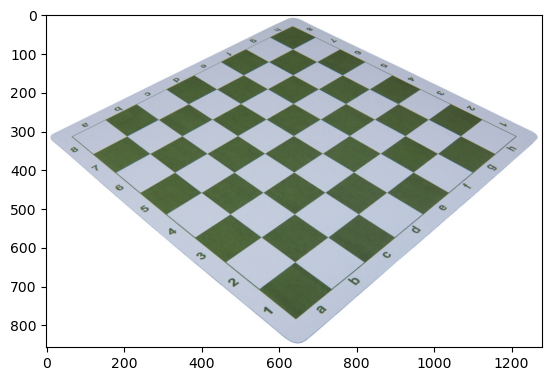

In [4]:
img = cv2.imread(image_path)
plt.imshow(img)

## Positioning

### Outline
Based on the previous tests we've decided to use the `cv2.canny` algorithm for now. It requires some fine tuning for the hyper-parameters, but we'll do that by hand for now and optimize the process later. For now we focus on showing that when we have a good outline, then we can indeed detect the board.

Text(0.5, 1.0, 'Canny')

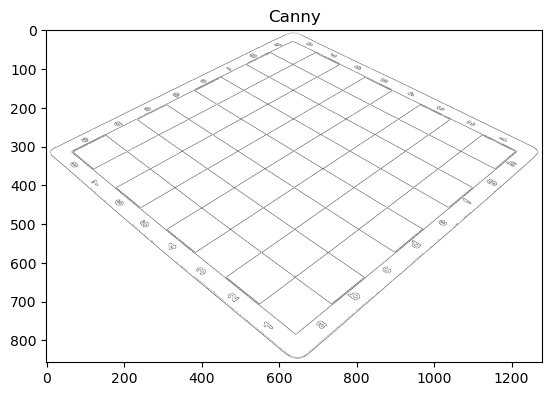

In [5]:
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

# Canny Edge Detection
canny = cv2.Canny(image=img_blur, threshold1=10, threshold2=55) # Canny Edge Detection

# plotting
plt.imshow(canny, cmap='Greys') 
plt.title("Canny")

The `cv2.Canny` output has the following properties:

In [6]:
print("shape:           ", canny.shape)
print("min value:       ", np.min(canny))
print("max value:       ", np.max(canny))
print("data type:       ", canny.dtype)
print("unique entries:  ", np.unique(canny))
print("non-zero entries:", np.where(canny != 0)[0].shape[0])

shape:            (857, 1280)
min value:        0
max value:        255
data type:        uint8
unique entries:   [  0 255]
non-zero entries: 25596


That's actually perfect because it has only two unique entries: 0 and 255.

### Cut it down: cropping
As a first step we remove all the whitespace around the image such that the edges touch the border on all sides.

In [7]:
len_y_canny, len_x_canny = canny.shape

In [8]:
cutoff = 0 #np.sqrt(4 * 255**2)

In [9]:
norms_horizontal = la.norm(canny, axis = 1)
norms_vertical = la.norm(canny, axis = 0)

cut_left = (norms_vertical > cutoff).argmax(axis=0)
cut_right = len_x_canny-(norms_vertical > cutoff)[::-1].argmax(axis=0)

cut_top = (norms_horizontal > cutoff).argmax(axis=0)
cut_bottom = len_y_canny-(norms_horizontal > cutoff)[::-1].argmax(axis=0)

In [10]:
test = [norms_vertical[cut_left] != 0,
        norms_vertical[cut_left-1] == 0,
        norms_vertical[cut_right-1] != 0,
        norms_vertical[cut_right] == 0,
        norms_horizontal[cut_top] != 0,
        norms_horizontal[cut_top-1] == 0,
        norms_horizontal[cut_bottom-1] != 0,
        norms_horizontal[cut_bottom] == 0]
print("Sanity check:", test)

Sanity check: [True, True, True, True, True, True, True, True]


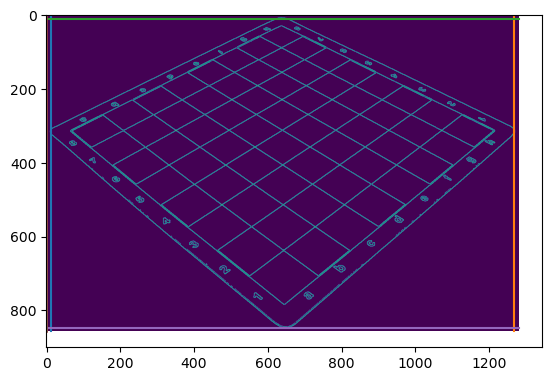

In [11]:
plt.imshow(canny)
plt.plot([cut_left, cut_left], [0, len_y_canny])
plt.plot([cut_right-1, cut_right-1], [0, len_y_canny])
plt.plot([0, len_x_canny], [cut_top, cut_top], [0, len_y_canny])
plt.plot([0, len_x_canny], [cut_bottom-1, cut_bottom-1], [0, len_y_canny])

In [12]:
crop = canny[:, cut_left:cut_right]
crop = crop[cut_top : cut_bottom, :]

Text(0.5, 1.0, 'cropped image')

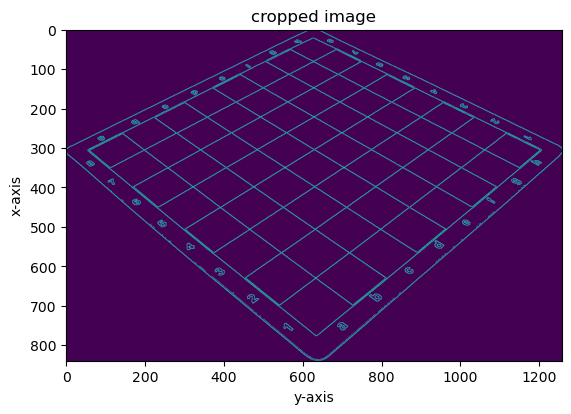

In [13]:
fig, ax = plt.subplots(1,1)
plt.imshow(crop)
ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("cropped image")

In [14]:
test = np.array([la.norm(crop[:, 0]), la.norm(crop[:, -1]), la.norm(crop[0, :]), la.norm(crop[:, 1])])
print("Sanity check:", (test != 0).all())

Sanity check: True


In [15]:
len_x, len_y = crop.shape
print("crop.shape = ({}, {})".format(len_x, len_y))

crop.shape = (840, 1258)


### Edge of the board

Let's start with the boarder that's directly towards the photographer.

In [16]:
spacing = 3

In [17]:
left = crop[:, 0 + spacing]
right = crop[:, -spacing]
bottom = crop[len_x - 1 - spacing, :]

left_lower = len_x - (left != 0)[::-1].argmax() - 1
right_lower = len_x - (right != 0)[::-1].argmax() - 1
bottom_left = (bottom != 0).argmax()
bottom_right = len_y - (bottom != 0)[::-1].argmax() - 1

test = [left[left_lower] != 0, 
        left[left_lower + 1] == 0, 
        right[right_lower] != 0,
        right[right_lower + 1] == 0,
        bottom[bottom_left] != 0, 
        bottom[bottom_left -1] == 0,
        bottom[bottom_right] != 0, 
        bottom[bottom_right +1] == 0
       ]

print("Sanity check:", all(test))

Sanity check: True


Text(0.5, 1.0, 'bottom edge of the whole board (not the play area)')

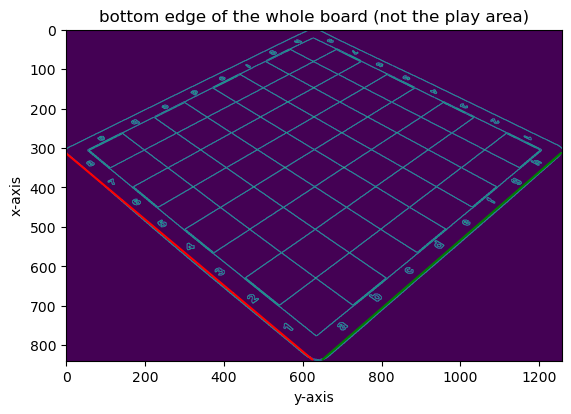

In [18]:
fig, ax = plt.subplots(1,1)

plt.imshow(crop)
plt.plot([bottom_left, 0+spacing], [len_x-1-spacing, left_lower], color = "r")
plt.plot([bottom_right, len_y-spacing], [len_x-1-spacing, right_lower], color = "g")

ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("bottom edge of the whole board (not the play area)")

### edge of the surface area

In [19]:
left_upper = (left != 0).argmax()
right_upper = (right != 0).argmax()

offset_left = left_lower - left_upper
offset_right = right_lower - right_upper

test = [left[left_upper] != 0, 
        left[left_upper - 1] == 0, 
        right[right_upper] != 0,
        right[right_upper - 1] == 0
       ]

print("Sanity check:", all(test))

Sanity check: True


In [20]:
slope_left = (len_x - spacing - left_lower) / (bottom_left - spacing)
slope_right = (len_x - spacing - right_lower) / (bottom_right - (len_y - 1 - spacing))

intersect_y = right_upper - left_upper + spacing * slope_left
intersect_y -= (slope_right * (len_y - 1 - spacing))
intersect_y /= (slope_left - slope_right)

intersect_x = left_upper + slope_left * (intersect_y - spacing)

In [21]:
x_left = left_upper
y_left = 0 + spacing

x_right = right_upper
y_right = len_y - 1 - spacing

x_bottom = intersect_x
y_bottom = intersect_y

Text(0.5, 1.0, "bottom edge of board's suface")

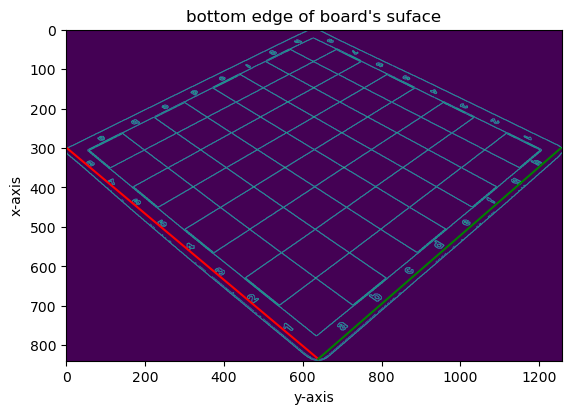

In [22]:
fig, ax = plt.subplots(1,1)

plt.imshow(crop)
plt.plot([y_left, y_bottom], [x_left, x_bottom], color = "r")
plt.plot([y_bottom, y_right], [x_bottom, x_right], color = "g")

ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("bottom edge of board's suface")

### edge of play area

In [23]:
def positions_along_line(start_x, start_y, stop_x, stop_y):
    
    direction = 1 if start_x < stop_x else -1
    slope = (stop_y - start_y) / (stop_x - start_x)

    x = np.arange(int(start_x), int(stop_x) + 1 * direction, direction, dtype = int)
    fx = (x - start_x) * slope + start_y
    
    return x, fx

In [24]:
def pixels_along_line(start_x, start_y, stop_x, stop_y):
    x, fx = positions_along_line(start_x, start_y, stop_x, stop_y)
    return x, np.floor(fx).astype(int)

Text(0.5, 1.0, "bottom edge of board's suface")

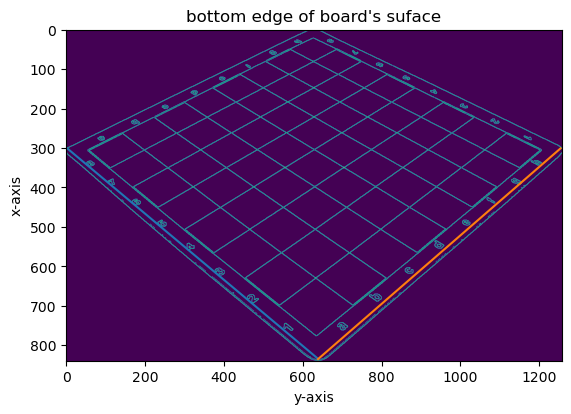

In [25]:
fig, ax = plt.subplots(1,1)

plt.imshow(crop)

x1, fx1 = positions_along_line(y_left, x_left, y_bottom, x_bottom)
plt.plot(x1, fx1)

x2, fx2 = positions_along_line(y_right, x_right, y_bottom, x_bottom)
plt.plot(x2, fx2)

ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("bottom edge of board's suface")

In [26]:
upwards = crop[:int(x_bottom)+1, int(y_bottom)][::-1]
start_bottom = int(x_bottom)
if upwards[0] == 0:
    stop_bottom = np.where(upwards != 0)[0][0]
else:
    temp = np.where(upwards == 0)[0][0]
    stop_bottom = temp + np.where(upwards[temp:] != 0)[0][0]
stop_bottom = x_bottom - stop_bottom

fxb, xb = positions_along_line(start_bottom, y_bottom, stop_bottom, y_bottom)

In [27]:
sideways = crop[int(x_left), y_left:]
start_left = int(y_left)
if sideways[0] == 0:
    stop_left = np.where(sideways != 0)[0][0]
else:
    temp = np.where(sideways == 0)[0][0]
    stop_left = temp + np.where(sideways[temp:] != 0)[0][0]
stop_left += start_left

xl, fxl = positions_along_line(start_left, x_left, stop_left, x_left)

In [28]:
sideways = crop[int(x_right), :y_right+1][::-1]
start_right = int(y_right)
if sideways[0] == 0:
    stop_right = np.where(sideways != 0)[0][0]
else:
    temp = np.where(sideways == 0)[0][0]
    stop_right = temp + np.where(sideways[temp:] != 0)[0][0]
stop_right = start_right - stop_right

xr, fxr = positions_along_line(start_right, x_right, stop_right, x_right)

Text(0.5, 1.0, "bottom edge of board's suface")

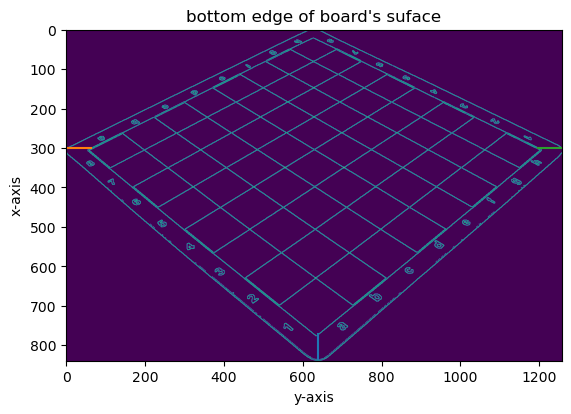

In [29]:
fig, ax = plt.subplots(1,1)

plt.imshow(crop)
plt.plot(xb, fxb)
plt.plot(xl, fxl)
plt.plot(xr, fxr)

ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("bottom edge of board's suface")

In [30]:
def nonzero_along_line(x, fx, img):
    pixels = crop[fx, x]
    return sum(pixels / 255)

In [31]:
def find_restriction(xb, fxb, xl, fxl):
    
#     fig, ax = plt.subplots(1,1)
#     plt.imshow(crop)
    
    N_b = xb.shape[0]
    N_l = xl.shape[0]
    
    for i in range(1, N_b+1):
        
        x_trial = fxb[-i]
        y_trial = xb[-i]
        
        for j in range(1, N_l+1):
            
            x_test = fxl[-j]
            y_test = xl[-j]
            
            x, fx = pixels_along_line(y_trial, x_trial, y_test, x_test)
            count = nonzero_along_line(x, fx, crop)
            x, fx = pixels_along_line(x_trial, y_trial, x_test, y_test)
            count = max(count, nonzero_along_line(fx, x, crop))
            
#             plt.plot(x, fx)
#             print(count)
            
            if count < 4:
#                 plt.plot(x, fx)
#                 print(count)
                return N_b - i, N_l - j
            
    print("None found")
    return 0, 0

In [32]:
i1, j1 = find_restriction(xb, fxb, xl, fxl)
i2, j2 = find_restriction(xb, fxb, xr, fxr)
i3, j3 = find_restriction(xl, fxl, xb, fxb)
i4, j4 = find_restriction(xr, fxr, xb, fxb)

x_left = xl[max([j1, i3])]
y_left = fxl[max([j1, i3])]

x_right = xr[max([j2, i4])]
y_right = fxr[max([j2, i4])]

x_bottom = xb[max([i1, i2, j3, j4])]
y_bottom = fxb[max([i1, i2, j3, j4])]

Text(0.5, 1.0, 'bottom edge of playing field')

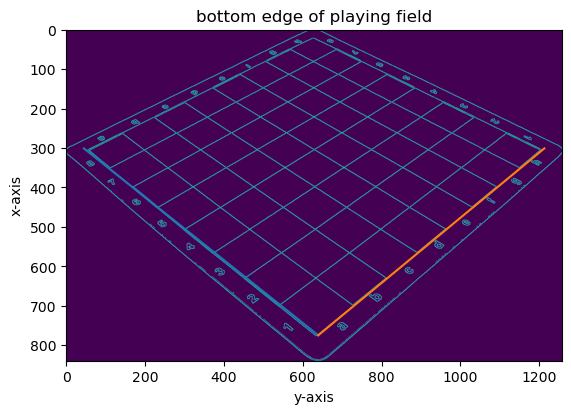

In [33]:
x, fx = pixels_along_line(400, len_x, 0, 400)
fig, ax = plt.subplots(1,1)

plt.imshow(crop)

# plt.plot([xb[i1], xl[j1]], [fxb[i1], fxl[j1]])
# plt.plot([xb[i2], xr[j2]], [fxb[i2], fxr[j2]])
# plt.plot([xb[j3], xl[i3]], [fxb[j3], fxl[i3]])
# plt.plot([xb[j4], xr[i4]], [fxb[j4], fxr[i4]])

plt.plot([x_left, x_bottom], [y_left, y_bottom])
plt.plot([x_right, x_bottom], [y_right, y_bottom])

ax.set_xlabel("y-axis")
ax.set_ylabel("x-axis")
ax.set_title("bottom edge of playing field")

## The End.

In [34]:
t_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} s = {} min".format(t_notebook, t_notebook / 60))

Runtime of this notebook: 3.02409291267395 s = 0.050401548544565834 min
